In [47]:
'1) Data Prep'

'''
This file prepares the MBTI source data. It does the following:
    - Imports the MBTI data sourced from: https://www.kaggle.com/datasnaek/mbti-type
    - Performs a basic spell check on the data
    - Normalizes the data
        - Normalizes without tokenization
        - Normalizes with tokenization
    - Performs SVD on the data to reduce the features
    - Saves the cleaned data a set of pickle files for modeling
'''

'\nThis file prepares the MBTI source data. It does the following:\n    - Imports the MBTI data sourced from: https://www.kaggle.com/datasnaek/mbti-type\n    - Performs a basic spell check on the data\n    - Normalizes the data\n        - Normalizes without tokenization\n        - Normalizes with tokenization\n    - Performs SVD on the data to reduce the features\n    - Saves the cleaned data a set of pickle files for modeling\n'

In [48]:
####Import libraries and modules
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import collections
import pickle

#Import Functions from Libraries
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.decomposition import TruncatedSVD
from datetime import datetime
from sklearn.model_selection import train_test_split

#Import user defined functions
from feature_extractors import *
from normalization import *
from spelling_corrector import *
from contractions import *

def bow_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = CountVectorizer(max_df=.85, min_df=.01, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [49]:
#Initalize Stop Words and Lemmatizer
stopword_list = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer() 

In [50]:
####Load the data
mbti = pd.read_csv("C:/Personal/Kaggle/mbti-myers-briggs-personality-type-dataset/mbti_1.csv") 
#Source: https://www.kaggle.com/datasnaek/mbti-type

#Print top five rows
print(mbti.head(5))

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


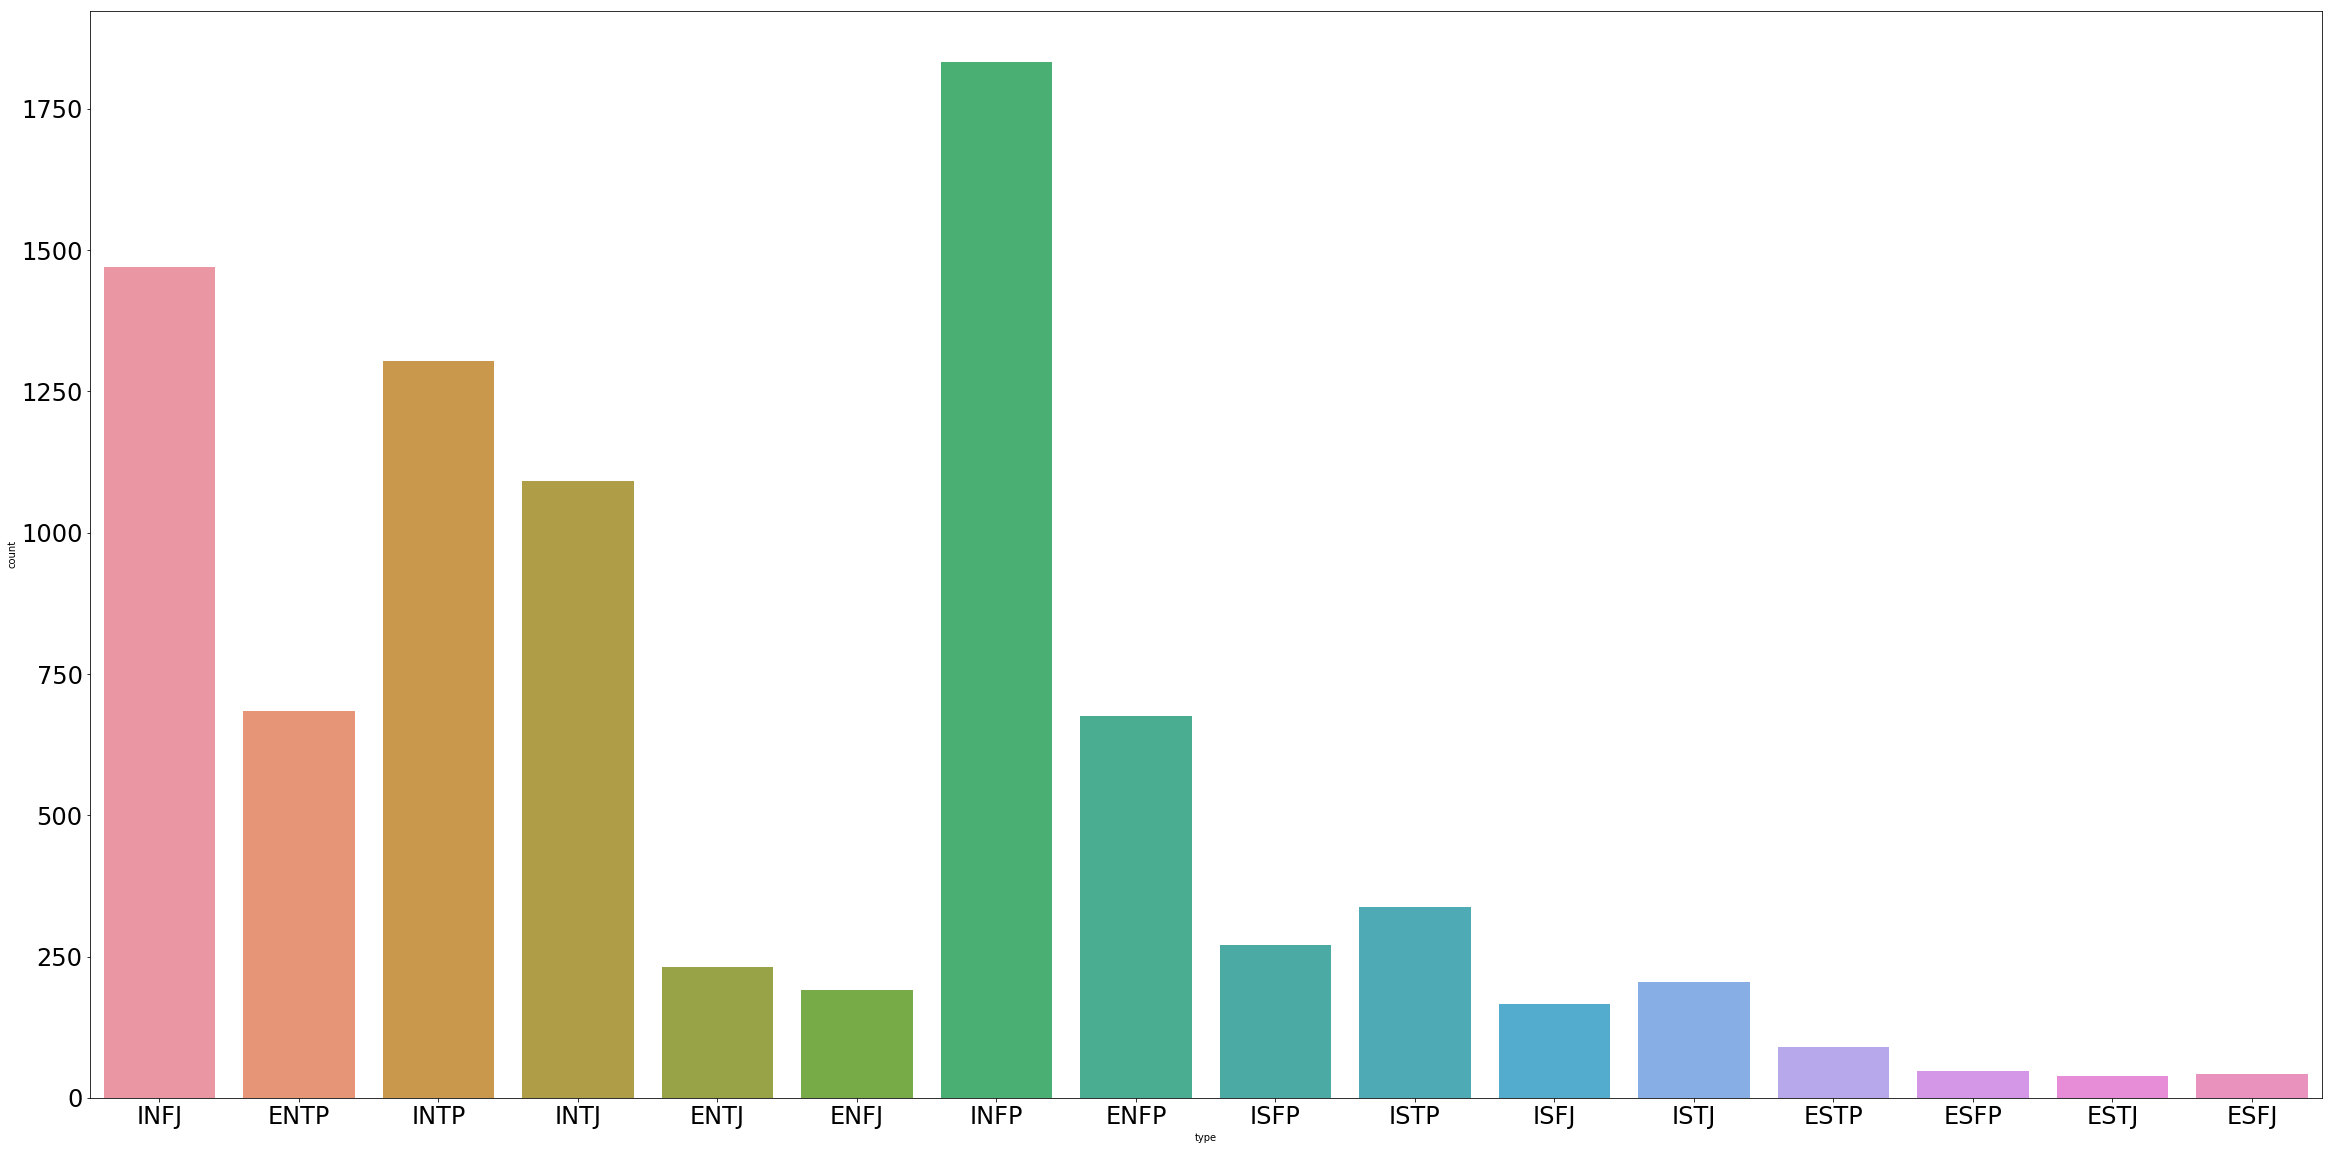

In [51]:
#Plot MBTI Type Distrbution
plt.figure(figsize=(40,20))
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=mbti, x='type')
plt.show()

In [52]:
####Reshape the Data into One row per comment per user

#Split the comments into a list of lists
dta = [p.split('|||') for p in mbti.posts.values]

#Cast as a dataframe
df = pd.DataFrame(dta)

#Set miissing as NAN
df[df==""] = np.nan
df[df.isnull()] = np.nan

#Remove extra columns
df = df.dropna(axis=1,how='all')

#Create column labels
b = []
for i in list(range(1, df.shape[1]+1)):
    b.append('s' + str(i))

#stack the columns
df.columns = b
df = df.stack()
df = df.reset_index()

#Merge the processed posts with the original MBTI type
df = df.rename(columns={'level_0': 'index'})
mbti2 = mbti.reset_index().drop('posts',axis=1)
df = pd.merge(df, mbti2, on='index')
df = df.rename(columns={'index': 'user','level_1': 'commentnum', 0:'comment'})

print()
print("Top Five Rows")
print(df.head())

print()
print("Shape of Dataframe")
print(df.shape)

print()
#Plot Number of comments Per User
mean_comment = df.groupby('user').agg('count')['commentnum'].mean()
print("Average number of comments per user " + str(round(mean_comment)))

mean_comment = df.groupby('user').agg('count')['commentnum'].min()
print("Min number of comments per user " + str(mean_comment))

mean_comment = df.groupby('user').agg('count')['commentnum'].max()
print("Max number of comments per user " + str(mean_comment))


Top Five Rows
   user commentnum                                            comment  type
0     0         s1        'http://www.youtube.com/watch?v=qsXHcwe3krw  INFJ
1     0         s2  http://41.media.tumblr.com/tumblr_lfouy03PMA1q...  INFJ
2     0         s3  enfp and intj moments  https://www.youtube.com...  INFJ
3     0         s4  What has been the most life-changing experienc...  INFJ
4     0         s5  http://www.youtube.com/watch?v=vXZeYwwRDw8   h...  INFJ

Shape of Dataframe
(421757, 4)

Average number of comments per user 49
Min number of comments per user 1
Max number of comments per user 59


In [53]:
#Convert MBIT to Class
unique_type_list = df.type.unique()
lab_encoder = LabelEncoder().fit(unique_type_list)

with open("LabelEncoder.pkl", "wb") as f:
    pickle.dump(lab_encoder, f, pickle.HIGHEST_PROTOCOL)

df['type_enc'] = lab_encoder.transform(df['type'])

#Replace Links
df['comment'] = df.comment.str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','url')

#Split comments based in pipes, replace with white space
df['comment'] = df.comment.str.replace('\|+',' ')

#Keep Only ASCII
df['comment'] = df.comment.str.replace('[^\x00-\x7F]+','')

#Remove Selected Puncation
df['comment'] = df.comment.str.replace('[,.:!@#$%&*()_+?><]+',' ')

#Remove Words Longer than 20 characters
df['comment'] = df.comment.str.replace('[a-zA-Z0-9_]{20,}',' ')                                       
                                       
#Remove Extra White Space
df['comment'] = df.comment.str.replace('[\s]+',' ')                                       
                                                                              
print(df.head())

   user commentnum                                            comment  type  \
0     0         s1                                               'url  INFJ   
1     0         s2                                                url  INFJ   
2     0         s3  enfp and intj moments url sportscenter not top...  INFJ   
3     0         s4  What has been the most life-changing experienc...  INFJ   
4     0         s5               url url On repeat for most of today   INFJ   

   type_enc  
0         8  
1         8  
2         8  
3         8  
4         8  


In [54]:
#Correct Spelling
#df = df[0:200] #Sample For Testing

#Correct Spelling
comments = df['comment'].tolist()
print(len(comments))
print(type(comments))
print()

dta = []
i = 0
for x in comments:
    if (i % 100 == 0):
        print(str(datetime.datetime.now()))
        print("Record " + str(i) + " of " + str(len(comments)))
    x = ' '.join([correct_text_generic(y) for y in x.split(' ')])
    dta.append(x)
    i += 1
                 
print(dta[0:2])
print()

421757
<class 'list'>

2017-12-30 21:43:41.309699
Record 0 of 421757
2017-12-30 21:43:50.489534
Record 100 of 421757
2017-12-30 21:43:59.643454
Record 200 of 421757
2017-12-30 21:44:15.765989
Record 300 of 421757
2017-12-30 21:44:26.063048
Record 400 of 421757
2017-12-30 21:44:42.380311
Record 500 of 421757
2017-12-30 21:44:54.970828
Record 600 of 421757
2017-12-30 21:45:09.593752
Record 700 of 421757
2017-12-30 21:45:24.673768
Record 800 of 421757
2017-12-30 21:45:49.500276
Record 900 of 421757
2017-12-30 21:46:10.217347
Record 1000 of 421757
2017-12-30 21:46:28.112136
Record 1100 of 421757
2017-12-30 21:46:40.388364
Record 1200 of 421757
2017-12-30 21:46:49.422267
Record 1300 of 421757
2017-12-30 21:46:56.527978
Record 1400 of 421757
2017-12-30 21:47:08.061131
Record 1500 of 421757
2017-12-30 21:47:16.847009
Record 1600 of 421757
2017-12-30 21:47:26.460971
Record 1700 of 421757
2017-12-30 21:47:32.806605
Record 1800 of 421757
2017-12-30 21:47:37.805105
Record 1900 of 421757
2017-12-3

2017-12-30 22:18:44.997806
Record 16600 of 421757
2017-12-30 22:19:02.757581
Record 16700 of 421757
2017-12-30 22:19:09.810287
Record 16800 of 421757
2017-12-30 22:19:25.829888
Record 16900 of 421757
2017-12-30 22:19:36.108916
Record 17000 of 421757
2017-12-30 22:19:46.347940
Record 17100 of 421757
2017-12-30 22:19:59.739279
Record 17200 of 421757
2017-12-30 22:20:12.529558
Record 17300 of 421757
2017-12-30 22:20:26.913996
Record 17400 of 421757
2017-12-30 22:20:41.606465
Record 17500 of 421757
2017-12-30 22:20:56.154920
Record 17600 of 421757
2017-12-30 22:21:03.195624
Record 17700 of 421757
2017-12-30 22:21:16.939998
Record 17800 of 421757
2017-12-30 22:21:26.900994
Record 17900 of 421757
2017-12-30 22:21:37.986103
Record 18000 of 421757
2017-12-30 22:21:47.016006
Record 18100 of 421757
2017-12-30 22:21:59.924296
Record 18200 of 421757
2017-12-30 22:22:09.333237
Record 18300 of 421757
2017-12-30 22:22:19.244228
Record 18400 of 421757
2017-12-30 22:22:33.034965
Record 18500 of 421757


2017-12-30 22:54:28.113428
Record 33000 of 421757
2017-12-30 22:54:42.255842
Record 33100 of 421757
2017-12-30 22:54:55.005117
Record 33200 of 421757
2017-12-30 22:55:08.538470
Record 33300 of 421757
2017-12-30 22:55:24.502066
Record 33400 of 421757
2017-12-30 22:55:29.711587
Record 33500 of 421757
2017-12-30 22:55:44.229039
Record 33600 of 421757
2017-12-30 22:55:54.021733
Record 33700 of 421757
2017-12-30 22:56:05.640733
Record 33800 of 421757
2017-12-30 22:56:18.535733
Record 33900 of 421757
2017-12-30 22:56:41.201733
Record 34000 of 421757
2017-12-30 22:56:50.084733
Record 34100 of 421757
2017-12-30 22:56:59.017733
Record 34200 of 421757
2017-12-30 22:57:11.488733
Record 34300 of 421757
2017-12-30 22:57:26.072733
Record 34400 of 421757
2017-12-30 22:57:38.093733
Record 34500 of 421757
2017-12-30 22:57:49.900733
Record 34600 of 421757
2017-12-30 22:57:59.617574
Record 34700 of 421757
2017-12-30 22:58:11.264739
Record 34800 of 421757
2017-12-30 22:58:25.306143
Record 34900 of 421757


2017-12-30 23:27:56.996811
Record 49400 of 421757
2017-12-30 23:28:11.551072
Record 49500 of 421757
2017-12-30 23:28:22.683072
Record 49600 of 421757
2017-12-30 23:28:34.685072
Record 49700 of 421757
2017-12-30 23:28:45.035072
Record 49800 of 421757
2017-12-30 23:28:57.612072
Record 49900 of 421757
2017-12-30 23:29:11.592072
Record 50000 of 421757
2017-12-30 23:29:20.236072
Record 50100 of 421757
2017-12-30 23:29:33.097072
Record 50200 of 421757
2017-12-30 23:29:42.353072
Record 50300 of 421757
2017-12-30 23:29:53.907336
Record 50400 of 421757
2017-12-30 23:30:04.897435
Record 50500 of 421757
2017-12-30 23:30:18.317777
Record 50600 of 421757
2017-12-30 23:30:29.387884
Record 50700 of 421757
2017-12-30 23:30:40.817027
Record 50800 of 421757
2017-12-30 23:30:52.741219
Record 50900 of 421757
2017-12-30 23:30:59.471892
Record 51000 of 421757
2017-12-30 23:31:17.336678
Record 51100 of 421757
2017-12-30 23:31:33.170261
Record 51200 of 421757
2017-12-30 23:31:45.502495
Record 51300 of 421757


2017-12-30 23:55:06.529193
Record 65800 of 421757
2017-12-30 23:55:18.415381
Record 65900 of 421757
2017-12-30 23:55:26.245164
Record 66000 of 421757
2017-12-30 23:55:39.981538
Record 66100 of 421757
2017-12-30 23:55:55.502090
Record 66200 of 421757
2017-12-30 23:56:04.669006
Record 66300 of 421757
2017-12-30 23:56:12.718811
Record 66400 of 421757
2017-12-30 23:56:20.841623
Record 66500 of 421757
2017-12-30 23:56:29.206460
Record 66600 of 421757
2017-12-30 23:56:36.113150
Record 66700 of 421757
2017-12-30 23:56:44.771016
Record 66800 of 421757
2017-12-30 23:56:55.650104
Record 66900 of 421757
2017-12-30 23:57:06.082147
Record 67000 of 421757
2017-12-30 23:57:17.795318
Record 67100 of 421757
2017-12-30 23:57:26.523191
Record 67200 of 421757
2017-12-30 23:57:33.499889
Record 67300 of 421757
2017-12-30 23:57:41.456684
Record 67400 of 421757
2017-12-30 23:57:53.007839
Record 67500 of 421757
2017-12-30 23:58:05.671105
Record 67600 of 421757
2017-12-30 23:58:17.802318
Record 67700 of 421757


2017-12-31 00:20:57.009436
Record 82200 of 421757
2017-12-31 00:21:09.104645
Record 82300 of 421757
2017-12-31 00:21:18.067541
Record 82400 of 421757
2017-12-31 00:21:24.321166
Record 82500 of 421757
2017-12-31 00:21:33.550089
Record 82600 of 421757
2017-12-31 00:21:39.676702
Record 82700 of 421757
2017-12-31 00:21:45.785313
Record 82800 of 421757
2017-12-31 00:21:54.815216
Record 82900 of 421757
2017-12-31 00:22:05.525286
Record 83000 of 421757
2017-12-31 00:22:13.001034
Record 83100 of 421757
2017-12-31 00:22:24.194153
Record 83200 of 421757
2017-12-31 00:22:32.888022
Record 83300 of 421757
2017-12-31 00:22:41.572891
Record 83400 of 421757
2017-12-31 00:22:49.754709
Record 83500 of 421757
2017-12-31 00:22:57.811515
Record 83600 of 421757
2017-12-31 00:23:08.658599
Record 83700 of 421757
2017-12-31 00:23:21.737907
Record 83800 of 421757
2017-12-31 00:23:29.836717
Record 83900 of 421757
2017-12-31 00:23:38.210554
Record 84000 of 421757
2017-12-31 00:23:51.466880
Record 84100 of 421757


2017-12-31 00:47:54.827797
Record 98600 of 421757
2017-12-31 00:48:03.849699
Record 98700 of 421757
2017-12-31 00:48:14.371751
Record 98800 of 421757
2017-12-31 00:48:28.351149
Record 98900 of 421757
2017-12-31 00:48:36.524966
Record 99000 of 421757
2017-12-31 00:48:48.814195
Record 99100 of 421757
2017-12-31 00:48:58.932207
Record 99200 of 421757
2017-12-31 00:49:11.136427
Record 99300 of 421757
2017-12-31 00:49:20.236337
Record 99400 of 421757
2017-12-31 00:49:27.526066
Record 99500 of 421757
2017-12-31 00:49:38.555169
Record 99600 of 421757
2017-12-31 00:49:48.668180
Record 99700 of 421757
2017-12-31 00:49:57.097023
Record 99800 of 421757
2017-12-31 00:50:05.028816
Record 99900 of 421757
2017-12-31 00:50:14.372750
Record 100000 of 421757
2017-12-31 00:50:21.844497
Record 100100 of 421757
2017-12-31 00:50:28.915204
Record 100200 of 421757
2017-12-31 00:50:36.825995
Record 100300 of 421757
2017-12-31 00:50:53.843697
Record 100400 of 421757
2017-12-31 00:51:04.715784
Record 100500 of 4

2017-12-31 01:13:56.408081
Record 114700 of 421757
2017-12-31 01:14:07.765216
Record 114800 of 421757
2017-12-31 01:14:17.061146
Record 114900 of 421757
2017-12-31 01:14:25.846024
Record 115000 of 421757
2017-12-31 01:14:40.071318
Record 115100 of 421757
2017-12-31 01:14:49.838318
Record 115200 of 421757
2017-12-31 01:15:02.327318
Record 115300 of 421757
2017-12-31 01:15:07.004318
Record 115400 of 421757
2017-12-31 01:15:17.621318
Record 115500 of 421757
2017-12-31 01:15:28.732318
Record 115600 of 421757
2017-12-31 01:15:38.961318
Record 115700 of 421757
2017-12-31 01:15:46.649318
Record 115800 of 421757
2017-12-31 01:15:54.140318
Record 115900 of 421757
2017-12-31 01:16:03.837318
Record 116000 of 421757
2017-12-31 01:16:14.945855
Record 116100 of 421757
2017-12-31 01:16:22.703631
Record 116200 of 421757
2017-12-31 01:16:28.521065
Record 116300 of 421757
2017-12-31 01:16:40.158065
Record 116400 of 421757
2017-12-31 01:16:50.437065
Record 116500 of 421757
2017-12-31 01:16:58.837065
Reco

2017-12-31 01:39:42.753387
Record 130800 of 421757
2017-12-31 01:39:50.488161
Record 130900 of 421757
2017-12-31 01:40:01.568269
Record 131000 of 421757
2017-12-31 01:40:06.832795
Record 131100 of 421757
2017-12-31 01:40:15.722684
Record 131200 of 421757
2017-12-31 01:40:22.117323
Record 131300 of 421757
2017-12-31 01:40:35.721684
Record 131400 of 421757
2017-12-31 01:40:43.384450
Record 131500 of 421757
2017-12-31 01:40:49.896101
Record 131600 of 421757
2017-12-31 01:40:59.014013
Record 131700 of 421757
2017-12-31 01:41:08.134925
Record 131800 of 421757
2017-12-31 01:41:14.435555
Record 131900 of 421757
2017-12-31 01:41:21.984309
Record 132000 of 421757
2017-12-31 01:41:30.818193
Record 132100 of 421757
2017-12-31 01:41:42.006311
Record 132200 of 421757
2017-12-31 01:41:51.780289
Record 132300 of 421757
2017-12-31 01:42:01.639274
Record 132400 of 421757
2017-12-31 01:42:11.681079
Record 132500 of 421757
2017-12-31 01:42:23.781079
Record 132600 of 421757
2017-12-31 01:42:35.109079
Reco

2017-12-31 02:04:54.023189
Record 146900 of 421757
2017-12-31 02:05:07.839189
Record 147000 of 421757
2017-12-31 02:05:14.079189
Record 147100 of 421757
2017-12-31 02:05:27.266189
Record 147200 of 421757
2017-12-31 02:05:34.205189
Record 147300 of 421757
2017-12-31 02:05:42.764189
Record 147400 of 421757
2017-12-31 02:05:54.153189
Record 147500 of 421757
2017-12-31 02:06:02.815189
Record 147600 of 421757
2017-12-31 02:06:12.341451
Record 147700 of 421757
2017-12-31 02:06:20.391256
Record 147800 of 421757
2017-12-31 02:06:31.762393
Record 147900 of 421757
2017-12-31 02:06:39.757192
Record 148000 of 421757
2017-12-31 02:06:46.080824
Record 148100 of 421757
2017-12-31 02:06:55.381754
Record 148200 of 421757
2017-12-31 02:07:05.036720
Record 148300 of 421757
2017-12-31 02:07:13.441560
Record 148400 of 421757
2017-12-31 02:07:21.467363
Record 148500 of 421757
2017-12-31 02:07:29.539170
Record 148600 of 421757
2017-12-31 02:07:38.172033
Record 148700 of 421757
2017-12-31 02:07:53.121528
Reco

2017-12-31 02:29:40.129297
Record 163000 of 421757
2017-12-31 02:29:46.482932
Record 163100 of 421757
2017-12-31 02:29:58.691153
Record 163200 of 421757
2017-12-31 02:30:07.836067
Record 163300 of 421757
2017-12-31 02:30:19.826266
Record 163400 of 421757
2017-12-31 02:30:28.568140
Record 163500 of 421757
2017-12-31 02:30:41.029386
Record 163600 of 421757
2017-12-31 02:30:53.701653
Record 163700 of 421757
2017-12-31 02:31:00.866370
Record 163800 of 421757
2017-12-31 02:31:13.888672
Record 163900 of 421757
2017-12-31 02:31:26.829966
Record 164000 of 421757
2017-12-31 02:31:35.278811
Record 164100 of 421757
2017-12-31 02:31:39.669250
Record 164200 of 421757
2017-12-31 02:31:48.404123
Record 164300 of 421757
2017-12-31 02:31:58.116094
Record 164400 of 421757
2017-12-31 02:32:08.121095
Record 164500 of 421757
2017-12-31 02:32:16.202903
Record 164600 of 421757
2017-12-31 02:32:23.793662
Record 164700 of 421757
2017-12-31 02:32:31.067389
Record 164800 of 421757
2017-12-31 02:32:39.596465
Reco

2017-12-31 02:54:42.603635
Record 179100 of 421757
2017-12-31 02:54:50.670442
Record 179200 of 421757
2017-12-31 02:55:05.024877
Record 179300 of 421757
2017-12-31 02:55:14.004775
Record 179400 of 421757
2017-12-31 02:55:25.719946
Record 179500 of 421757
2017-12-31 02:55:30.457420
Record 179600 of 421757
2017-12-31 02:55:39.197294
Record 179700 of 421757
2017-12-31 02:55:47.514125
Record 179800 of 421757
2017-12-31 02:55:55.728947
Record 179900 of 421757
2017-12-31 02:56:00.799454
Record 180000 of 421757
2017-12-31 02:56:08.577232
Record 180100 of 421757
2017-12-31 02:56:15.612935
Record 180200 of 421757
2017-12-31 02:56:27.044078
Record 180300 of 421757
2017-12-31 02:56:35.171101
Record 180400 of 421757
2017-12-31 02:56:47.247101
Record 180500 of 421757
2017-12-31 02:56:55.171101
Record 180600 of 421757
2017-12-31 02:57:03.315101
Record 180700 of 421757
2017-12-31 02:57:13.519101
Record 180800 of 421757
2017-12-31 02:57:22.420101
Record 180900 of 421757
2017-12-31 02:57:29.204101
Reco

2017-12-31 03:20:11.755414
Record 195200 of 421757
2017-12-31 03:20:21.714414
Record 195300 of 421757
2017-12-31 03:20:28.698414
Record 195400 of 421757
2017-12-31 03:20:36.214414
Record 195500 of 421757
2017-12-31 03:20:46.675414
Record 195600 of 421757
2017-12-31 03:20:55.067414
Record 195700 of 421757
2017-12-31 03:21:09.548414
Record 195800 of 421757
2017-12-31 03:21:19.515414
Record 195900 of 421757
2017-12-31 03:21:27.377414
Record 196000 of 421757
2017-12-31 03:21:35.307414
Record 196100 of 421757
2017-12-31 03:21:43.116414
Record 196200 of 421757
2017-12-31 03:21:50.345414
Record 196300 of 421757
2017-12-31 03:21:59.366414
Record 196400 of 421757
2017-12-31 03:22:10.102414
Record 196500 of 421757
2017-12-31 03:22:26.779063
Record 196600 of 421757
2017-12-31 03:22:35.914977
Record 196700 of 421757
2017-12-31 03:22:47.532139
Record 196800 of 421757
2017-12-31 03:22:54.926878
Record 196900 of 421757
2017-12-31 03:23:02.881673
Record 197000 of 421757
2017-12-31 03:23:14.547840
Reco

2017-12-31 03:45:31.470429
Record 211300 of 421757
2017-12-31 03:45:40.613343
Record 211400 of 421757
2017-12-31 03:45:50.425324
Record 211500 of 421757
2017-12-31 03:45:58.499131
Record 211600 of 421757
2017-12-31 03:46:04.157697
Record 211700 of 421757
2017-12-31 03:46:13.456627
Record 211800 of 421757
2017-12-31 03:46:30.341083
Record 211900 of 421757
2017-12-31 03:46:36.829083
Record 212000 of 421757
2017-12-31 03:46:42.449083
Record 212100 of 421757
2017-12-31 03:46:54.503083
Record 212200 of 421757
2017-12-31 03:47:01.196083
Record 212300 of 421757
2017-12-31 03:47:16.041083
Record 212400 of 421757
2017-12-31 03:47:27.245083
Record 212500 of 421757
2017-12-31 03:47:39.968083
Record 212600 of 421757
2017-12-31 03:47:49.104083
Record 212700 of 421757
2017-12-31 03:47:59.448083
Record 212800 of 421757
2017-12-31 03:48:05.906083
Record 212900 of 421757
2017-12-31 03:48:16.698754
Record 213000 of 421757
2017-12-31 03:48:25.990683
Record 213100 of 421757
2017-12-31 03:48:32.910375
Reco

2017-12-31 04:11:05.199540
Record 227400 of 421757
2017-12-31 04:11:11.487540
Record 227500 of 421757
2017-12-31 04:11:17.468540
Record 227600 of 421757
2017-12-31 04:11:24.038540
Record 227700 of 421757
2017-12-31 04:11:33.834540
Record 227800 of 421757
2017-12-31 04:11:43.362540
Record 227900 of 421757
2017-12-31 04:11:52.917540
Record 228000 of 421757
2017-12-31 04:12:07.239540
Record 228100 of 421757
2017-12-31 04:12:14.120944
Record 228200 of 421757
2017-12-31 04:12:22.894822
Record 228300 of 421757
2017-12-31 04:12:33.350867
Record 228400 of 421757
2017-12-31 04:12:45.665098
Record 228500 of 421757
2017-12-31 04:12:55.769109
Record 228600 of 421757
2017-12-31 04:13:06.199152
Record 228700 of 421757
2017-12-31 04:13:13.408873
Record 228800 of 421757
2017-12-31 04:13:20.471579
Record 228900 of 421757
2017-12-31 04:13:29.890521
Record 229000 of 421757
2017-12-31 04:13:40.084540
Record 229100 of 421757
2017-12-31 04:13:47.807312
Record 229200 of 421757
2017-12-31 04:14:00.287560
Reco

2017-12-31 04:36:21.071911
Record 243500 of 421757
2017-12-31 04:36:29.937911
Record 243600 of 421757
2017-12-31 04:36:38.334911
Record 243700 of 421757
2017-12-31 04:36:45.475911
Record 243800 of 421757
2017-12-31 04:36:50.373911
Record 243900 of 421757
2017-12-31 04:36:57.366911
Record 244000 of 421757
2017-12-31 04:37:08.538911
Record 244100 of 421757
2017-12-31 04:37:17.808911
Record 244200 of 421757
2017-12-31 04:37:27.963911
Record 244300 of 421757
2017-12-31 04:37:39.189911
Record 244400 of 421757
2017-12-31 04:37:49.593911
Record 244500 of 421757
2017-12-31 04:37:53.989911
Record 244600 of 421757
2017-12-31 04:38:05.568911
Record 244700 of 421757
2017-12-31 04:38:16.154502
Record 244800 of 421757
2017-12-31 04:38:23.808268
Record 244900 of 421757
2017-12-31 04:38:33.305183
Record 245000 of 421757
2017-12-31 04:38:42.658183
Record 245100 of 421757
2017-12-31 04:38:55.039183
Record 245200 of 421757
2017-12-31 04:39:00.283183
Record 245300 of 421757
2017-12-31 04:39:09.675183
Reco

2017-12-31 05:01:24.726614
Record 259600 of 421757
2017-12-31 05:01:33.651507
Record 259700 of 421757
2017-12-31 05:01:41.054247
Record 259800 of 421757
2017-12-31 05:01:48.815023
Record 259900 of 421757
2017-12-31 05:01:58.771018
Record 260000 of 421757
2017-12-31 05:02:12.292370
Record 260100 of 421757
2017-12-31 05:02:21.443285
Record 260200 of 421757
2017-12-31 05:02:31.349276
Record 260300 of 421757
2017-12-31 05:02:43.539495
Record 260400 of 421757
2017-12-31 05:03:01.806321
Record 260500 of 421757
2017-12-31 05:03:07.552896
Record 260600 of 421757
2017-12-31 05:03:13.134454
Record 260700 of 421757
2017-12-31 05:03:21.834324
Record 260800 of 421757
2017-12-31 05:03:29.994140
Record 260900 of 421757
2017-12-31 05:03:37.712912
Record 261000 of 421757
2017-12-31 05:03:48.742014
Record 261100 of 421757
2017-12-31 05:03:59.058046
Record 261200 of 421757
2017-12-31 05:04:08.891029
Record 261300 of 421757
2017-12-31 05:04:21.183167
Record 261400 of 421757
2017-12-31 05:04:34.717167
Reco

2017-12-31 05:26:59.832774
Record 275700 of 421757
2017-12-31 05:27:09.635774
Record 275800 of 421757
2017-12-31 05:27:18.406774
Record 275900 of 421757
2017-12-31 05:27:28.683774
Record 276000 of 421757
2017-12-31 05:27:36.691774
Record 276100 of 421757
2017-12-31 05:27:47.698774
Record 276200 of 421757
2017-12-31 05:28:00.733774
Record 276300 of 421757
2017-12-31 05:28:07.944774
Record 276400 of 421757
2017-12-31 05:28:19.400774
Record 276500 of 421757
2017-12-31 05:28:30.144774
Record 276600 of 421757
2017-12-31 05:28:37.816525
Record 276700 of 421757
2017-12-31 05:28:49.888732
Record 276800 of 421757
2017-12-31 05:28:58.177561
Record 276900 of 421757
2017-12-31 05:29:05.133256
Record 277000 of 421757
2017-12-31 05:29:13.911134
Record 277100 of 421757
2017-12-31 05:29:23.955138
Record 277200 of 421757
2017-12-31 05:29:31.277871
Record 277300 of 421757
2017-12-31 05:29:42.783021
Record 277400 of 421757
2017-12-31 05:29:54.417184
Record 277500 of 421757
2017-12-31 05:30:01.524895
Reco

2017-12-31 05:52:38.634526
Record 291800 of 421757
2017-12-31 05:52:49.469609
Record 291900 of 421757
2017-12-31 05:53:00.014664
Record 292000 of 421757
2017-12-31 05:53:09.612623
Record 292100 of 421757
2017-12-31 05:53:20.073669
Record 292200 of 421757
2017-12-31 05:53:27.819444
Record 292300 of 421757
2017-12-31 05:53:38.231485
Record 292400 of 421757
2017-12-31 05:53:45.700232
Record 292500 of 421757
2017-12-31 05:53:55.728234
Record 292600 of 421757
2017-12-31 05:54:09.202582
Record 292700 of 421757
2017-12-31 05:54:18.694531
Record 292800 of 421757
2017-12-31 05:54:27.622423
Record 292900 of 421757
2017-12-31 05:54:37.680429
Record 293000 of 421757
2017-12-31 05:54:45.011162
Record 293100 of 421757
2017-12-31 05:54:52.331894
Record 293200 of 421757
2017-12-31 05:55:04.162077
Record 293300 of 421757
2017-12-31 05:55:15.573218
Record 293400 of 421757
2017-12-31 05:55:24.068067
Record 293500 of 421757
2017-12-31 05:55:34.623123
Record 293600 of 421757
2017-12-31 05:55:45.885249
Reco

2017-12-31 06:17:58.429696
Record 307900 of 421757
2017-12-31 06:18:07.389592
Record 308000 of 421757
2017-12-31 06:18:12.303083
Record 308100 of 421757
2017-12-31 06:18:22.451098
Record 308200 of 421757
2017-12-31 06:18:29.713824
Record 308300 of 421757
2017-12-31 06:18:41.115964
Record 308400 of 421757
2017-12-31 06:18:49.489554
Record 308500 of 421757
2017-12-31 06:18:59.626554
Record 308600 of 421757
2017-12-31 06:19:09.925554
Record 308700 of 421757
2017-12-31 06:19:17.077554
Record 308800 of 421757
2017-12-31 06:19:25.949554
Record 308900 of 421757
2017-12-31 06:19:37.615554
Record 309000 of 421757
2017-12-31 06:19:51.143554
Record 309100 of 421757
2017-12-31 06:20:01.071222
Record 309200 of 421757
2017-12-31 06:20:06.678783
Record 309300 of 421757
2017-12-31 06:20:14.710586
Record 309400 of 421757
2017-12-31 06:20:20.234138
Record 309500 of 421757
2017-12-31 06:20:25.342649
Record 309600 of 421757
2017-12-31 06:20:38.229938
Record 309700 of 421757
2017-12-31 06:20:44.590574
Reco

2017-12-31 06:42:53.109356
Record 324000 of 421757
2017-12-31 06:43:06.560701
Record 324100 of 421757
2017-12-31 06:43:14.315476
Record 324200 of 421757
2017-12-31 06:43:25.416586
Record 324300 of 421757
2017-12-31 06:43:34.709515
Record 324400 of 421757
2017-12-31 06:43:49.959040
Record 324500 of 421757
2017-12-31 06:43:56.741718
Record 324600 of 421757
2017-12-31 06:44:03.871431
Record 324700 of 421757
2017-12-31 06:44:19.735017
Record 324800 of 421757
2017-12-31 06:44:29.197964
Record 324900 of 421757
2017-12-31 06:44:34.412485
Record 325000 of 421757
2017-12-31 06:44:43.679412
Record 325100 of 421757
2017-12-31 06:44:50.481092
Record 325200 of 421757
2017-12-31 06:45:00.320076
Record 325300 of 421757
2017-12-31 06:45:09.490993
Record 325400 of 421757
2017-12-31 06:45:20.126056
Record 325500 of 421757
2017-12-31 06:45:28.412885
Record 325600 of 421757
2017-12-31 06:45:39.142957
Record 325700 of 421757
2017-12-31 06:45:48.788922
Record 325800 of 421757
2017-12-31 06:45:56.913734
Reco

2017-12-31 07:07:55.462260
Record 340100 of 421757
2017-12-31 07:08:06.866260
Record 340200 of 421757
2017-12-31 07:08:13.248674
Record 340300 of 421757
2017-12-31 07:08:22.142564
Record 340400 of 421757
2017-12-31 07:08:30.368386
Record 340500 of 421757
2017-12-31 07:08:43.448694
Record 340600 of 421757
2017-12-31 07:08:52.414590
Record 340700 of 421757
2017-12-31 07:09:01.338483
Record 340800 of 421757
2017-12-31 07:09:06.878037
Record 340900 of 421757
2017-12-31 07:09:13.459695
Record 341000 of 421757
2017-12-31 07:09:20.775426
Record 341100 of 421757
2017-12-31 07:09:28.992248
Record 341200 of 421757
2017-12-31 07:09:38.387187
Record 341300 of 421757
2017-12-31 07:09:48.591208
Record 341400 of 421757
2017-12-31 07:09:56.525001
Record 341500 of 421757
2017-12-31 07:10:07.481096
Record 341600 of 421757
2017-12-31 07:10:18.456194
Record 341700 of 421757
2017-12-31 07:10:28.963014
Record 341800 of 421757
2017-12-31 07:10:40.306014
Record 341900 of 421757
2017-12-31 07:10:55.177014
Reco

2017-12-31 07:33:33.638549
Record 356200 of 421757
2017-12-31 07:33:46.719857
Record 356300 of 421757
2017-12-31 07:34:01.462331
Record 356400 of 421757
2017-12-31 07:34:08.530038
Record 356500 of 421757
2017-12-31 07:34:17.505935
Record 356600 of 421757
2017-12-31 07:34:26.977882
Record 356700 of 421757
2017-12-31 07:34:34.427627
Record 356800 of 421757
2017-12-31 07:34:44.489633
Record 356900 of 421757
2017-12-31 07:34:51.077292
Record 357000 of 421757
2017-12-31 07:35:00.316216
Record 357100 of 421757
2017-12-31 07:35:12.482432
Record 357200 of 421757
2017-12-31 07:35:23.949579
Record 357300 of 421757
2017-12-31 07:35:34.228607
Record 357400 of 421757
2017-12-31 07:35:42.388422
Record 357500 of 421757
2017-12-31 07:35:50.465230
Record 357600 of 421757
2017-12-31 07:36:02.574441
Record 357700 of 421757
2017-12-31 07:36:16.788862
Record 357800 of 421757
2017-12-31 07:36:29.299113
Record 357900 of 421757
2017-12-31 07:36:35.704117
Record 358000 of 421757
2017-12-31 07:36:42.834117
Reco

2017-12-31 07:59:11.385212
Record 372300 of 421757
2017-12-31 07:59:19.103983
Record 372400 of 421757
2017-12-31 07:59:31.213194
Record 372500 of 421757
2017-12-31 07:59:43.960469
Record 372600 of 421757
2017-12-31 07:59:51.455218
Record 372700 of 421757
2017-12-31 08:00:05.015574
Record 372800 of 421757
2017-12-31 08:00:17.266144
Record 372900 of 421757
2017-12-31 08:00:26.741144
Record 373000 of 421757
2017-12-31 08:00:35.947540
Record 373100 of 421757
2017-12-31 08:00:49.067851
Record 373200 of 421757
2017-12-31 08:01:01.207065
Record 373300 of 421757
2017-12-31 08:01:12.230167
Record 373400 of 421757
2017-12-31 08:01:29.136858
Record 373500 of 421757
2017-12-31 08:01:36.753620
Record 373600 of 421757
2017-12-31 08:01:44.232367
Record 373700 of 421757
2017-12-31 08:01:52.050149
Record 373800 of 421757
2017-12-31 08:02:02.355179
Record 373900 of 421757
2017-12-31 08:02:11.987015
Record 374000 of 421757
2017-12-31 08:02:24.744015
Record 374100 of 421757
2017-12-31 08:02:32.725015
Reco

2017-12-31 08:24:17.576917
Record 388400 of 421757
2017-12-31 08:24:28.525917
Record 388500 of 421757
2017-12-31 08:24:38.015917
Record 388600 of 421757
2017-12-31 08:24:48.440917
Record 388700 of 421757
2017-12-31 08:24:55.968917
Record 388800 of 421757
2017-12-31 08:25:08.733917
Record 388900 of 421757
2017-12-31 08:25:18.590917
Record 389000 of 421757
2017-12-31 08:25:25.008917
Record 389100 of 421757
2017-12-31 08:25:34.240917
Record 389200 of 421757
2017-12-31 08:25:48.360917
Record 389300 of 421757
2017-12-31 08:26:00.950917
Record 389400 of 421757
2017-12-31 08:26:07.665917
Record 389500 of 421757
2017-12-31 08:26:16.507917
Record 389600 of 421757
2017-12-31 08:26:27.772161
Record 389700 of 421757
2017-12-31 08:26:37.021085
Record 389800 of 421757
2017-12-31 08:26:44.959879
Record 389900 of 421757
2017-12-31 08:26:55.846968
Record 390000 of 421757
2017-12-31 08:27:07.603143
Record 390100 of 421757
2017-12-31 08:27:15.851968
Record 390200 of 421757
2017-12-31 08:27:25.497933
Reco

2017-12-31 08:50:22.744522
Record 404500 of 421757
2017-12-31 08:50:30.044252
Record 404600 of 421757
2017-12-31 08:50:39.916239
Record 404700 of 421757
2017-12-31 08:50:48.384086
Record 404800 of 421757
2017-12-31 08:50:59.235171
Record 404900 of 421757
2017-12-31 08:51:07.638011
Record 405000 of 421757
2017-12-31 08:51:18.343082
Record 405100 of 421757
2017-12-31 08:51:23.916639
Record 405200 of 421757
2017-12-31 08:51:34.583706
Record 405300 of 421757
2017-12-31 08:51:43.456593
Record 405400 of 421757
2017-12-31 08:51:58.766124
Record 405500 of 421757
2017-12-31 08:52:07.608008
Record 405600 of 421757
2017-12-31 08:52:17.668014
Record 405700 of 421757
2017-12-31 08:52:27.621009
Record 405800 of 421757
2017-12-31 08:52:36.427889
Record 405900 of 421757
2017-12-31 08:52:43.829629
Record 406000 of 421757
2017-12-31 08:52:54.035650
Record 406100 of 421757
2017-12-31 08:53:03.259572
Record 406200 of 421757
2017-12-31 08:53:11.634410
Record 406300 of 421757
2017-12-31 08:53:19.084155
Reco

2017-12-31 09:15:18.636695
Record 420600 of 421757
2017-12-31 09:15:24.963328
Record 420700 of 421757
2017-12-31 09:15:38.639695
Record 420800 of 421757
2017-12-31 09:16:01.201951
Record 420900 of 421757
2017-12-31 09:16:13.512182
Record 421000 of 421757
2017-12-31 09:16:25.790410
Record 421100 of 421757
2017-12-31 09:16:35.776408
Record 421200 of 421757
2017-12-31 09:16:50.287859
Record 421300 of 421757
2017-12-31 09:17:01.582989
Record 421400 of 421757
2017-12-31 09:17:10.638894
Record 421500 of 421757
2017-12-31 09:17:20.768907
Record 421600 of 421757
2017-12-31 09:17:29.178748
Record 421700 of 421757
["'url", 'url']



In [55]:
###Normalize Data
#No Tokenization
dta_notoken = normalize_corpus(dta, tokenize=False, contraction=CONTRACTION_MAP)
print(dta_notoken[0:2])
print()

clean = pd.DataFrame({'clean_comment':dta_notoken})
cleaned = pd.concat([df, clean], axis=1)
print(cleaned[0:2])
print()

cleaned.to_pickle("cleaned_mbti_cmtlvl.pkl")

####################################################################3
#Tokenization
dta_token = normalize_corpus(dta, tokenize=True, contraction=CONTRACTION_MAP)
print(dta_token[0:2])
print()

clean = pd.DataFrame(dta_token)
cleaned = pd.concat([df, clean], axis=1)
print(cleaned[0:2])
print()

cleaned.to_pickle("cleaned_mbti_token_cmtlvl.pkl")

Record 0 of 421757
Record 100 of 421757
Record 200 of 421757
Record 300 of 421757
Record 400 of 421757
Record 500 of 421757
Record 600 of 421757
Record 700 of 421757
Record 800 of 421757
Record 900 of 421757
Record 1000 of 421757
Record 1100 of 421757
Record 1200 of 421757
Record 1300 of 421757
Record 1400 of 421757
Record 1500 of 421757
Record 1600 of 421757
Record 1700 of 421757
Record 1800 of 421757
Record 1900 of 421757
Record 2000 of 421757
Record 2100 of 421757
Record 2200 of 421757
Record 2300 of 421757
Record 2400 of 421757
Record 2500 of 421757
Record 2600 of 421757
Record 2700 of 421757
Record 2800 of 421757
Record 2900 of 421757
Record 3000 of 421757
Record 3100 of 421757
Record 3200 of 421757
Record 3300 of 421757
Record 3400 of 421757
Record 3500 of 421757
Record 3600 of 421757
Record 3700 of 421757
Record 3800 of 421757
Record 3900 of 421757
Record 4000 of 421757
Record 4100 of 421757
Record 4200 of 421757
Record 4300 of 421757
Record 4400 of 421757
Record 4500 of 421757


Record 36200 of 421757
Record 36300 of 421757
Record 36400 of 421757
Record 36500 of 421757
Record 36600 of 421757
Record 36700 of 421757
Record 36800 of 421757
Record 36900 of 421757
Record 37000 of 421757
Record 37100 of 421757
Record 37200 of 421757
Record 37300 of 421757
Record 37400 of 421757
Record 37500 of 421757
Record 37600 of 421757
Record 37700 of 421757
Record 37800 of 421757
Record 37900 of 421757
Record 38000 of 421757
Record 38100 of 421757
Record 38200 of 421757
Record 38300 of 421757
Record 38400 of 421757
Record 38500 of 421757
Record 38600 of 421757
Record 38700 of 421757
Record 38800 of 421757
Record 38900 of 421757
Record 39000 of 421757
Record 39100 of 421757
Record 39200 of 421757
Record 39300 of 421757
Record 39400 of 421757
Record 39500 of 421757
Record 39600 of 421757
Record 39700 of 421757
Record 39800 of 421757
Record 39900 of 421757
Record 40000 of 421757
Record 40100 of 421757
Record 40200 of 421757
Record 40300 of 421757
Record 40400 of 421757
Record 4050

Record 71900 of 421757
Record 72000 of 421757
Record 72100 of 421757
Record 72200 of 421757
Record 72300 of 421757
Record 72400 of 421757
Record 72500 of 421757
Record 72600 of 421757
Record 72700 of 421757
Record 72800 of 421757
Record 72900 of 421757
Record 73000 of 421757
Record 73100 of 421757
Record 73200 of 421757
Record 73300 of 421757
Record 73400 of 421757
Record 73500 of 421757
Record 73600 of 421757
Record 73700 of 421757
Record 73800 of 421757
Record 73900 of 421757
Record 74000 of 421757
Record 74100 of 421757
Record 74200 of 421757
Record 74300 of 421757
Record 74400 of 421757
Record 74500 of 421757
Record 74600 of 421757
Record 74700 of 421757
Record 74800 of 421757
Record 74900 of 421757
Record 75000 of 421757
Record 75100 of 421757
Record 75200 of 421757
Record 75300 of 421757
Record 75400 of 421757
Record 75500 of 421757
Record 75600 of 421757
Record 75700 of 421757
Record 75800 of 421757
Record 75900 of 421757
Record 76000 of 421757
Record 76100 of 421757
Record 7620

Record 107300 of 421757
Record 107400 of 421757
Record 107500 of 421757
Record 107600 of 421757
Record 107700 of 421757
Record 107800 of 421757
Record 107900 of 421757
Record 108000 of 421757
Record 108100 of 421757
Record 108200 of 421757
Record 108300 of 421757
Record 108400 of 421757
Record 108500 of 421757
Record 108600 of 421757
Record 108700 of 421757
Record 108800 of 421757
Record 108900 of 421757
Record 109000 of 421757
Record 109100 of 421757
Record 109200 of 421757
Record 109300 of 421757
Record 109400 of 421757
Record 109500 of 421757
Record 109600 of 421757
Record 109700 of 421757
Record 109800 of 421757
Record 109900 of 421757
Record 110000 of 421757
Record 110100 of 421757
Record 110200 of 421757
Record 110300 of 421757
Record 110400 of 421757
Record 110500 of 421757
Record 110600 of 421757
Record 110700 of 421757
Record 110800 of 421757
Record 110900 of 421757
Record 111000 of 421757
Record 111100 of 421757
Record 111200 of 421757
Record 111300 of 421757
Record 111400 of

Record 141500 of 421757
Record 141600 of 421757
Record 141700 of 421757
Record 141800 of 421757
Record 141900 of 421757
Record 142000 of 421757
Record 142100 of 421757
Record 142200 of 421757
Record 142300 of 421757
Record 142400 of 421757
Record 142500 of 421757
Record 142600 of 421757
Record 142700 of 421757
Record 142800 of 421757
Record 142900 of 421757
Record 143000 of 421757
Record 143100 of 421757
Record 143200 of 421757
Record 143300 of 421757
Record 143400 of 421757
Record 143500 of 421757
Record 143600 of 421757
Record 143700 of 421757
Record 143800 of 421757
Record 143900 of 421757
Record 144000 of 421757
Record 144100 of 421757
Record 144200 of 421757
Record 144300 of 421757
Record 144400 of 421757
Record 144500 of 421757
Record 144600 of 421757
Record 144700 of 421757
Record 144800 of 421757
Record 144900 of 421757
Record 145000 of 421757
Record 145100 of 421757
Record 145200 of 421757
Record 145300 of 421757
Record 145400 of 421757
Record 145500 of 421757
Record 145600 of

Record 175700 of 421757
Record 175800 of 421757
Record 175900 of 421757
Record 176000 of 421757
Record 176100 of 421757
Record 176200 of 421757
Record 176300 of 421757
Record 176400 of 421757
Record 176500 of 421757
Record 176600 of 421757
Record 176700 of 421757
Record 176800 of 421757
Record 176900 of 421757
Record 177000 of 421757
Record 177100 of 421757
Record 177200 of 421757
Record 177300 of 421757
Record 177400 of 421757
Record 177500 of 421757
Record 177600 of 421757
Record 177700 of 421757
Record 177800 of 421757
Record 177900 of 421757
Record 178000 of 421757
Record 178100 of 421757
Record 178200 of 421757
Record 178300 of 421757
Record 178400 of 421757
Record 178500 of 421757
Record 178600 of 421757
Record 178700 of 421757
Record 178800 of 421757
Record 178900 of 421757
Record 179000 of 421757
Record 179100 of 421757
Record 179200 of 421757
Record 179300 of 421757
Record 179400 of 421757
Record 179500 of 421757
Record 179600 of 421757
Record 179700 of 421757
Record 179800 of

Record 209900 of 421757
Record 210000 of 421757
Record 210100 of 421757
Record 210200 of 421757
Record 210300 of 421757
Record 210400 of 421757
Record 210500 of 421757
Record 210600 of 421757
Record 210700 of 421757
Record 210800 of 421757
Record 210900 of 421757
Record 211000 of 421757
Record 211100 of 421757
Record 211200 of 421757
Record 211300 of 421757
Record 211400 of 421757
Record 211500 of 421757
Record 211600 of 421757
Record 211700 of 421757
Record 211800 of 421757
Record 211900 of 421757
Record 212000 of 421757
Record 212100 of 421757
Record 212200 of 421757
Record 212300 of 421757
Record 212400 of 421757
Record 212500 of 421757
Record 212600 of 421757
Record 212700 of 421757
Record 212800 of 421757
Record 212900 of 421757
Record 213000 of 421757
Record 213100 of 421757
Record 213200 of 421757
Record 213300 of 421757
Record 213400 of 421757
Record 213500 of 421757
Record 213600 of 421757
Record 213700 of 421757
Record 213800 of 421757
Record 213900 of 421757
Record 214000 of

Record 244100 of 421757
Record 244200 of 421757
Record 244300 of 421757
Record 244400 of 421757
Record 244500 of 421757
Record 244600 of 421757
Record 244700 of 421757
Record 244800 of 421757
Record 244900 of 421757
Record 245000 of 421757
Record 245100 of 421757
Record 245200 of 421757
Record 245300 of 421757
Record 245400 of 421757
Record 245500 of 421757
Record 245600 of 421757
Record 245700 of 421757
Record 245800 of 421757
Record 245900 of 421757
Record 246000 of 421757
Record 246100 of 421757
Record 246200 of 421757
Record 246300 of 421757
Record 246400 of 421757
Record 246500 of 421757
Record 246600 of 421757
Record 246700 of 421757
Record 246800 of 421757
Record 246900 of 421757
Record 247000 of 421757
Record 247100 of 421757
Record 247200 of 421757
Record 247300 of 421757
Record 247400 of 421757
Record 247500 of 421757
Record 247600 of 421757
Record 247700 of 421757
Record 247800 of 421757
Record 247900 of 421757
Record 248000 of 421757
Record 248100 of 421757
Record 248200 of

Record 278300 of 421757
Record 278400 of 421757
Record 278500 of 421757
Record 278600 of 421757
Record 278700 of 421757
Record 278800 of 421757
Record 278900 of 421757
Record 279000 of 421757
Record 279100 of 421757
Record 279200 of 421757
Record 279300 of 421757
Record 279400 of 421757
Record 279500 of 421757
Record 279600 of 421757
Record 279700 of 421757
Record 279800 of 421757
Record 279900 of 421757
Record 280000 of 421757
Record 280100 of 421757
Record 280200 of 421757
Record 280300 of 421757
Record 280400 of 421757
Record 280500 of 421757
Record 280600 of 421757
Record 280700 of 421757
Record 280800 of 421757
Record 280900 of 421757
Record 281000 of 421757
Record 281100 of 421757
Record 281200 of 421757
Record 281300 of 421757
Record 281400 of 421757
Record 281500 of 421757
Record 281600 of 421757
Record 281700 of 421757
Record 281800 of 421757
Record 281900 of 421757
Record 282000 of 421757
Record 282100 of 421757
Record 282200 of 421757
Record 282300 of 421757
Record 282400 of

Record 312500 of 421757
Record 312600 of 421757
Record 312700 of 421757
Record 312800 of 421757
Record 312900 of 421757
Record 313000 of 421757
Record 313100 of 421757
Record 313200 of 421757
Record 313300 of 421757
Record 313400 of 421757
Record 313500 of 421757
Record 313600 of 421757
Record 313700 of 421757
Record 313800 of 421757
Record 313900 of 421757
Record 314000 of 421757
Record 314100 of 421757
Record 314200 of 421757
Record 314300 of 421757
Record 314400 of 421757
Record 314500 of 421757
Record 314600 of 421757
Record 314700 of 421757
Record 314800 of 421757
Record 314900 of 421757
Record 315000 of 421757
Record 315100 of 421757
Record 315200 of 421757
Record 315300 of 421757
Record 315400 of 421757
Record 315500 of 421757
Record 315600 of 421757
Record 315700 of 421757
Record 315800 of 421757
Record 315900 of 421757
Record 316000 of 421757
Record 316100 of 421757
Record 316200 of 421757
Record 316300 of 421757
Record 316400 of 421757
Record 316500 of 421757
Record 316600 of

Record 346700 of 421757
Record 346800 of 421757
Record 346900 of 421757
Record 347000 of 421757
Record 347100 of 421757
Record 347200 of 421757
Record 347300 of 421757
Record 347400 of 421757
Record 347500 of 421757
Record 347600 of 421757
Record 347700 of 421757
Record 347800 of 421757
Record 347900 of 421757
Record 348000 of 421757
Record 348100 of 421757
Record 348200 of 421757
Record 348300 of 421757
Record 348400 of 421757
Record 348500 of 421757
Record 348600 of 421757
Record 348700 of 421757
Record 348800 of 421757
Record 348900 of 421757
Record 349000 of 421757
Record 349100 of 421757
Record 349200 of 421757
Record 349300 of 421757
Record 349400 of 421757
Record 349500 of 421757
Record 349600 of 421757
Record 349700 of 421757
Record 349800 of 421757
Record 349900 of 421757
Record 350000 of 421757
Record 350100 of 421757
Record 350200 of 421757
Record 350300 of 421757
Record 350400 of 421757
Record 350500 of 421757
Record 350600 of 421757
Record 350700 of 421757
Record 350800 of

Record 380900 of 421757
Record 381000 of 421757
Record 381100 of 421757
Record 381200 of 421757
Record 381300 of 421757
Record 381400 of 421757
Record 381500 of 421757
Record 381600 of 421757
Record 381700 of 421757
Record 381800 of 421757
Record 381900 of 421757
Record 382000 of 421757
Record 382100 of 421757
Record 382200 of 421757
Record 382300 of 421757
Record 382400 of 421757
Record 382500 of 421757
Record 382600 of 421757
Record 382700 of 421757
Record 382800 of 421757
Record 382900 of 421757
Record 383000 of 421757
Record 383100 of 421757
Record 383200 of 421757
Record 383300 of 421757
Record 383400 of 421757
Record 383500 of 421757
Record 383600 of 421757
Record 383700 of 421757
Record 383800 of 421757
Record 383900 of 421757
Record 384000 of 421757
Record 384100 of 421757
Record 384200 of 421757
Record 384300 of 421757
Record 384400 of 421757
Record 384500 of 421757
Record 384600 of 421757
Record 384700 of 421757
Record 384800 of 421757
Record 384900 of 421757
Record 385000 of

Record 415100 of 421757
Record 415200 of 421757
Record 415300 of 421757
Record 415400 of 421757
Record 415500 of 421757
Record 415600 of 421757
Record 415700 of 421757
Record 415800 of 421757
Record 415900 of 421757
Record 416000 of 421757
Record 416100 of 421757
Record 416200 of 421757
Record 416300 of 421757
Record 416400 of 421757
Record 416500 of 421757
Record 416600 of 421757
Record 416700 of 421757
Record 416800 of 421757
Record 416900 of 421757
Record 417000 of 421757
Record 417100 of 421757
Record 417200 of 421757
Record 417300 of 421757
Record 417400 of 421757
Record 417500 of 421757
Record 417600 of 421757
Record 417700 of 421757
Record 417800 of 421757
Record 417900 of 421757
Record 418000 of 421757
Record 418100 of 421757
Record 418200 of 421757
Record 418300 of 421757
Record 418400 of 421757
Record 418500 of 421757
Record 418600 of 421757
Record 418700 of 421757
Record 418800 of 421757
Record 418900 of 421757
Record 419000 of 421757
Record 419100 of 421757
Record 419200 of

Record 28300 of 421757
Record 28400 of 421757
Record 28500 of 421757
Record 28600 of 421757
Record 28700 of 421757
Record 28800 of 421757
Record 28900 of 421757
Record 29000 of 421757
Record 29100 of 421757
Record 29200 of 421757
Record 29300 of 421757
Record 29400 of 421757
Record 29500 of 421757
Record 29600 of 421757
Record 29700 of 421757
Record 29800 of 421757
Record 29900 of 421757
Record 30000 of 421757
Record 30100 of 421757
Record 30200 of 421757
Record 30300 of 421757
Record 30400 of 421757
Record 30500 of 421757
Record 30600 of 421757
Record 30700 of 421757
Record 30800 of 421757
Record 30900 of 421757
Record 31000 of 421757
Record 31100 of 421757
Record 31200 of 421757
Record 31300 of 421757
Record 31400 of 421757
Record 31500 of 421757
Record 31600 of 421757
Record 31700 of 421757
Record 31800 of 421757
Record 31900 of 421757
Record 32000 of 421757
Record 32100 of 421757
Record 32200 of 421757
Record 32300 of 421757
Record 32400 of 421757
Record 32500 of 421757
Record 3260

Record 64000 of 421757
Record 64100 of 421757
Record 64200 of 421757
Record 64300 of 421757
Record 64400 of 421757
Record 64500 of 421757
Record 64600 of 421757
Record 64700 of 421757
Record 64800 of 421757
Record 64900 of 421757
Record 65000 of 421757
Record 65100 of 421757
Record 65200 of 421757
Record 65300 of 421757
Record 65400 of 421757
Record 65500 of 421757
Record 65600 of 421757
Record 65700 of 421757
Record 65800 of 421757
Record 65900 of 421757
Record 66000 of 421757
Record 66100 of 421757
Record 66200 of 421757
Record 66300 of 421757
Record 66400 of 421757
Record 66500 of 421757
Record 66600 of 421757
Record 66700 of 421757
Record 66800 of 421757
Record 66900 of 421757
Record 67000 of 421757
Record 67100 of 421757
Record 67200 of 421757
Record 67300 of 421757
Record 67400 of 421757
Record 67500 of 421757
Record 67600 of 421757
Record 67700 of 421757
Record 67800 of 421757
Record 67900 of 421757
Record 68000 of 421757
Record 68100 of 421757
Record 68200 of 421757
Record 6830

Record 99700 of 421757
Record 99800 of 421757
Record 99900 of 421757
Record 100000 of 421757
Record 100100 of 421757
Record 100200 of 421757
Record 100300 of 421757
Record 100400 of 421757
Record 100500 of 421757
Record 100600 of 421757
Record 100700 of 421757
Record 100800 of 421757
Record 100900 of 421757
Record 101000 of 421757
Record 101100 of 421757
Record 101200 of 421757
Record 101300 of 421757
Record 101400 of 421757
Record 101500 of 421757
Record 101600 of 421757
Record 101700 of 421757
Record 101800 of 421757
Record 101900 of 421757
Record 102000 of 421757
Record 102100 of 421757
Record 102200 of 421757
Record 102300 of 421757
Record 102400 of 421757
Record 102500 of 421757
Record 102600 of 421757
Record 102700 of 421757
Record 102800 of 421757
Record 102900 of 421757
Record 103000 of 421757
Record 103100 of 421757
Record 103200 of 421757
Record 103300 of 421757
Record 103400 of 421757
Record 103500 of 421757
Record 103600 of 421757
Record 103700 of 421757
Record 103800 of 42

Record 133900 of 421757
Record 134000 of 421757
Record 134100 of 421757
Record 134200 of 421757
Record 134300 of 421757
Record 134400 of 421757
Record 134500 of 421757
Record 134600 of 421757
Record 134700 of 421757
Record 134800 of 421757
Record 134900 of 421757
Record 135000 of 421757
Record 135100 of 421757
Record 135200 of 421757
Record 135300 of 421757
Record 135400 of 421757
Record 135500 of 421757
Record 135600 of 421757
Record 135700 of 421757
Record 135800 of 421757
Record 135900 of 421757
Record 136000 of 421757
Record 136100 of 421757
Record 136200 of 421757
Record 136300 of 421757
Record 136400 of 421757
Record 136500 of 421757
Record 136600 of 421757
Record 136700 of 421757
Record 136800 of 421757
Record 136900 of 421757
Record 137000 of 421757
Record 137100 of 421757
Record 137200 of 421757
Record 137300 of 421757
Record 137400 of 421757
Record 137500 of 421757
Record 137600 of 421757
Record 137700 of 421757
Record 137800 of 421757
Record 137900 of 421757
Record 138000 of

Record 168100 of 421757
Record 168200 of 421757
Record 168300 of 421757
Record 168400 of 421757
Record 168500 of 421757
Record 168600 of 421757
Record 168700 of 421757
Record 168800 of 421757
Record 168900 of 421757
Record 169000 of 421757
Record 169100 of 421757
Record 169200 of 421757
Record 169300 of 421757
Record 169400 of 421757
Record 169500 of 421757
Record 169600 of 421757
Record 169700 of 421757
Record 169800 of 421757
Record 169900 of 421757
Record 170000 of 421757
Record 170100 of 421757
Record 170200 of 421757
Record 170300 of 421757
Record 170400 of 421757
Record 170500 of 421757
Record 170600 of 421757
Record 170700 of 421757
Record 170800 of 421757
Record 170900 of 421757
Record 171000 of 421757
Record 171100 of 421757
Record 171200 of 421757
Record 171300 of 421757
Record 171400 of 421757
Record 171500 of 421757
Record 171600 of 421757
Record 171700 of 421757
Record 171800 of 421757
Record 171900 of 421757
Record 172000 of 421757
Record 172100 of 421757
Record 172200 of

Record 202300 of 421757
Record 202400 of 421757
Record 202500 of 421757
Record 202600 of 421757
Record 202700 of 421757
Record 202800 of 421757
Record 202900 of 421757
Record 203000 of 421757
Record 203100 of 421757
Record 203200 of 421757
Record 203300 of 421757
Record 203400 of 421757
Record 203500 of 421757
Record 203600 of 421757
Record 203700 of 421757
Record 203800 of 421757
Record 203900 of 421757
Record 204000 of 421757
Record 204100 of 421757
Record 204200 of 421757
Record 204300 of 421757
Record 204400 of 421757
Record 204500 of 421757
Record 204600 of 421757
Record 204700 of 421757
Record 204800 of 421757
Record 204900 of 421757
Record 205000 of 421757
Record 205100 of 421757
Record 205200 of 421757
Record 205300 of 421757
Record 205400 of 421757
Record 205500 of 421757
Record 205600 of 421757
Record 205700 of 421757
Record 205800 of 421757
Record 205900 of 421757
Record 206000 of 421757
Record 206100 of 421757
Record 206200 of 421757
Record 206300 of 421757
Record 206400 of

Record 236500 of 421757
Record 236600 of 421757
Record 236700 of 421757
Record 236800 of 421757
Record 236900 of 421757
Record 237000 of 421757
Record 237100 of 421757
Record 237200 of 421757
Record 237300 of 421757
Record 237400 of 421757
Record 237500 of 421757
Record 237600 of 421757
Record 237700 of 421757
Record 237800 of 421757
Record 237900 of 421757
Record 238000 of 421757
Record 238100 of 421757
Record 238200 of 421757
Record 238300 of 421757
Record 238400 of 421757
Record 238500 of 421757
Record 238600 of 421757
Record 238700 of 421757
Record 238800 of 421757
Record 238900 of 421757
Record 239000 of 421757
Record 239100 of 421757
Record 239200 of 421757
Record 239300 of 421757
Record 239400 of 421757
Record 239500 of 421757
Record 239600 of 421757
Record 239700 of 421757
Record 239800 of 421757
Record 239900 of 421757
Record 240000 of 421757
Record 240100 of 421757
Record 240200 of 421757
Record 240300 of 421757
Record 240400 of 421757
Record 240500 of 421757
Record 240600 of

Record 270700 of 421757
Record 270800 of 421757
Record 270900 of 421757
Record 271000 of 421757
Record 271100 of 421757
Record 271200 of 421757
Record 271300 of 421757
Record 271400 of 421757
Record 271500 of 421757
Record 271600 of 421757
Record 271700 of 421757
Record 271800 of 421757
Record 271900 of 421757
Record 272000 of 421757
Record 272100 of 421757
Record 272200 of 421757
Record 272300 of 421757
Record 272400 of 421757
Record 272500 of 421757
Record 272600 of 421757
Record 272700 of 421757
Record 272800 of 421757
Record 272900 of 421757
Record 273000 of 421757
Record 273100 of 421757
Record 273200 of 421757
Record 273300 of 421757
Record 273400 of 421757
Record 273500 of 421757
Record 273600 of 421757
Record 273700 of 421757
Record 273800 of 421757
Record 273900 of 421757
Record 274000 of 421757
Record 274100 of 421757
Record 274200 of 421757
Record 274300 of 421757
Record 274400 of 421757
Record 274500 of 421757
Record 274600 of 421757
Record 274700 of 421757
Record 274800 of

Record 305000 of 421757
Record 305100 of 421757
Record 305200 of 421757
Record 305300 of 421757
Record 305400 of 421757
Record 305500 of 421757
Record 305600 of 421757
Record 305700 of 421757
Record 305800 of 421757
Record 305900 of 421757
Record 306000 of 421757
Record 306100 of 421757
Record 306200 of 421757
Record 306300 of 421757
Record 306400 of 421757
Record 306500 of 421757
Record 306600 of 421757
Record 306700 of 421757
Record 306800 of 421757
Record 306900 of 421757
Record 307000 of 421757
Record 307100 of 421757
Record 307200 of 421757
Record 307300 of 421757
Record 307400 of 421757
Record 307500 of 421757
Record 307600 of 421757
Record 307700 of 421757
Record 307800 of 421757
Record 307900 of 421757
Record 308000 of 421757
Record 308100 of 421757
Record 308200 of 421757
Record 308300 of 421757
Record 308400 of 421757
Record 308500 of 421757
Record 308600 of 421757
Record 308700 of 421757
Record 308800 of 421757
Record 308900 of 421757
Record 309000 of 421757
Record 309100 of

Record 339200 of 421757
Record 339300 of 421757
Record 339400 of 421757
Record 339500 of 421757
Record 339600 of 421757
Record 339700 of 421757
Record 339800 of 421757
Record 339900 of 421757
Record 340000 of 421757
Record 340100 of 421757
Record 340200 of 421757
Record 340300 of 421757
Record 340400 of 421757
Record 340500 of 421757
Record 340600 of 421757
Record 340700 of 421757
Record 340800 of 421757
Record 340900 of 421757
Record 341000 of 421757
Record 341100 of 421757
Record 341200 of 421757
Record 341300 of 421757
Record 341400 of 421757
Record 341500 of 421757
Record 341600 of 421757
Record 341700 of 421757
Record 341800 of 421757
Record 341900 of 421757
Record 342000 of 421757
Record 342100 of 421757
Record 342200 of 421757
Record 342300 of 421757
Record 342400 of 421757
Record 342500 of 421757
Record 342600 of 421757
Record 342700 of 421757
Record 342800 of 421757
Record 342900 of 421757
Record 343000 of 421757
Record 343100 of 421757
Record 343200 of 421757
Record 343300 of

Record 373400 of 421757
Record 373500 of 421757
Record 373600 of 421757
Record 373700 of 421757
Record 373800 of 421757
Record 373900 of 421757
Record 374000 of 421757
Record 374100 of 421757
Record 374200 of 421757
Record 374300 of 421757
Record 374400 of 421757
Record 374500 of 421757
Record 374600 of 421757
Record 374700 of 421757
Record 374800 of 421757
Record 374900 of 421757
Record 375000 of 421757
Record 375100 of 421757
Record 375200 of 421757
Record 375300 of 421757
Record 375400 of 421757
Record 375500 of 421757
Record 375600 of 421757
Record 375700 of 421757
Record 375800 of 421757
Record 375900 of 421757
Record 376000 of 421757
Record 376100 of 421757
Record 376200 of 421757
Record 376300 of 421757
Record 376400 of 421757
Record 376500 of 421757
Record 376600 of 421757
Record 376700 of 421757
Record 376800 of 421757
Record 376900 of 421757
Record 377000 of 421757
Record 377100 of 421757
Record 377200 of 421757
Record 377300 of 421757
Record 377400 of 421757
Record 377500 of

Record 407600 of 421757
Record 407700 of 421757
Record 407800 of 421757
Record 407900 of 421757
Record 408000 of 421757
Record 408100 of 421757
Record 408200 of 421757
Record 408300 of 421757
Record 408400 of 421757
Record 408500 of 421757
Record 408600 of 421757
Record 408700 of 421757
Record 408800 of 421757
Record 408900 of 421757
Record 409000 of 421757
Record 409100 of 421757
Record 409200 of 421757
Record 409300 of 421757
Record 409400 of 421757
Record 409500 of 421757
Record 409600 of 421757
Record 409700 of 421757
Record 409800 of 421757
Record 409900 of 421757
Record 410000 of 421757
Record 410100 of 421757
Record 410200 of 421757
Record 410300 of 421757
Record 410400 of 421757
Record 410500 of 421757
Record 410600 of 421757
Record 410700 of 421757
Record 410800 of 421757
Record 410900 of 421757
Record 411000 of 421757
Record 411100 of 421757
Record 411200 of 421757
Record 411300 of 421757
Record 411400 of 421757
Record 411500 of 421757
Record 411600 of 421757
Record 411700 of

In [56]:
#Train Test Split
X = dta_notoken
y = df['type_enc']
print(len(X))
print(len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

print(len(X_train))
print(X_train[:2])
print()

print(len(X_test))
print(X_test[:2])
print()

print(len(y_train))
print(y_train[:2])
print()

print(len(y_test))
print(y_test[:2])
print()


421757
421757
379581
['identity isfj one know different hard around long test really low j really high might', 'unpopular opinion time like idea language desire learn second language come us ability communicate someone specie']

42176
['confront well alone try something spray eye kick ball', 'oh yeah course single nearly 23 year get bit silly scout internet girl thread new part search']

379581
175576    15
4479      11
Name: type_enc, dtype: int64

42176
90921      9
380158    10
Name: type_enc, dtype: int64



In [57]:
#Feature Extraction
bow_vectorizor, bow_features = bow_extractor(X_train, ngram_range=(1,1))
bow_features = bow_features.todense()
print("bow_features shape: " + str(bow_features.shape))

tfidf_vectorizor, tfidf_features = tfidf_transformer(bow_features)
tfidf_features = tfidf_features.todense()
print("tfidf_features shape: " + str(tfidf_features.shape))

bow_features_test = bow_vectorizor.transform(X_test)
bow_features_test = bow_features_test.todense()
print("bow_features_test shape: " + str(bow_features_test.shape))

tfidf_features_test = tfidf_vectorizor.transform(bow_features_test)
tfidf_features_test = tfidf_features_test.todense()
print("tfidf_features_test shape: " + str(tfidf_features_test.shape))

bow_features shape: (379581, 206)
tfidf_features shape: (379581, 206)
bow_features_test shape: (42176, 206)
tfidf_features_test shape: (42176, 206)


In [58]:
#Save Processed Data to Disk
clean_bow = pd.DataFrame(bow_features)
cleaned_bow = pd.concat([y_train.reset_index(), clean_bow], axis=1)
cleaned_bow.to_pickle("cleaned_bow_train_cmtlvl.pkl")

clean_tfidf = pd.DataFrame(tfidf_features)
cleaned_tfidf = pd.concat([y_train.reset_index(), clean_tfidf], axis=1)
cleaned_tfidf.to_pickle("cleaned_tfidf_train_cmtlvl.pkl")

clean_bow = pd.DataFrame(bow_features_test)
cleaned_bow = pd.concat([y_test.reset_index(), clean_bow], axis=1)
cleaned_bow.to_pickle("cleaned_bow_test_cmtlvl.pkl")

clean_tfidf = pd.DataFrame(tfidf_features_test)
cleaned_tfidf = pd.concat([y_test.reset_index(), clean_tfidf], axis=1)
cleaned_tfidf.to_pickle("cleaned_tfidf_test_cmtlvl.pkl")

In [59]:
#SVD

#BOW SVD
svd = TruncatedSVD(n_components=150)
svd.fit(bow_features)
bow_features_svd = svd.transform(bow_features)
bow_features_svd = pd.DataFrame(bow_features_svd)
bow_features_svd = pd.concat([y_train.reset_index(), bow_features_svd], axis=1)
bow_features_svd.to_pickle("cleaned_bow_train_cmtlvl_svd.pkl")

bow_features_test_svd = svd.transform(bow_features_test)
bow_features_test_svd = pd.DataFrame(bow_features_test_svd)
bow_features_test_svd = pd.concat([y_test.reset_index(), bow_features_test_svd], axis=1)
bow_features_test_svd.to_pickle("cleaned_bow_test_cmtlvl_svd.pkl")

#TFIDF SVD
svd = TruncatedSVD(n_components=150)
svd.fit(tfidf_features)
tfidf_features_svd = svd.transform(tfidf_features)
tfidf_features_svd = pd.DataFrame(tfidf_features_svd)
tfidf_features_svd = pd.concat([y_train.reset_index(), tfidf_features_svd], axis=1)
tfidf_features_svd.to_pickle("cleaned_tfidf_train_cmtlvl_svd.pkl")

tfidf_features_test_svd = svd.transform(tfidf_features_test)
tfidf_features_test_svd = pd.DataFrame(tfidf_features_test_svd)
tfidf_features_test_svd = pd.concat([y_test.reset_index(), tfidf_features_test_svd], axis=1)
tfidf_features_test_svd.to_pickle("cleaned_tfidf_test_cmtlvl_svd.pkl")